# Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import tensorflow
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

import pygad

2024-12-09 12:59:56.531428: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-09 12:59:56.532984: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-09 12:59:56.554857: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-09 12:59:56.554884: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-09 12:59:56.555557: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

# Carga de datos

In [5]:
archivo_csv = '/home/ubuntu2202/Desktop/datasets/X-IIoTID dataset/X-IIoTID dataset.csv'
df_dataset = pd.read_csv(archivo_csv)
print(len(df_dataset))

/tmp/ipykernel_18025/3377469678.py:2: DtypeWarning: Columns (1,3,5,12,24) have mixed types. Specify dtype option on import or set low_memory=False.
  df_dataset = pd.read_csv(archivo_csv)


820834


In [6]:
# Imprimir la cantidad de valores únicos para cada columna
valores_unicos = df_dataset.nunique()
print('cantidad de valores únicos por columna')
for columna, cantidad in valores_unicos.items():
    print(f'{columna}: {cantidad}')

cantidad de valores únicos por columna
Date: 49
Timestamp: 273175
Scr_IP: 36
Scr_port: 94481
Des_IP: 96
Des_port: 10610
Protocol: 4
Service: 17
Duration: 330207
Scr_bytes: 21054
Des_bytes: 51899
Conn_state: 2
missed_bytes: 249
is_syn_only: 2
Is_SYN_ACK: 2
is_pure_ack: 2
is_with_payload: 2
FIN or RST: 2
Bad_checksum: 1
is_SYN_with_RST: 1
Scr_pkts: 1211
Scr_ip_bytes: 32872
Des_pkts: 1556
Des_ip_bytes: 55574
anomaly_alert: 5
total_bytes: 62464
total_packet: 2216
paket_rate: 303353
byte_rate: 339658
Scr_packts_ratio: 19995
Des_pkts_ratio: 19995
Scr_bytes_ratio: 72716
Des_bytes_ratio: 72716
Avg_user_time: 12635
Std_user_time: 51646
Avg_nice_time: 4551
Std_nice_time: 50541
Avg_system_time: 5174
Std_system_time: 50456
Avg_iowait_time: 10157
Std_iowait_time: 30703
Avg_ideal_time: 19705
Std_ideal_time: 51725
Avg_tps: 3736
Std_tps: 21771
Avg_rtps: 2254
Std_rtps: 16492
Avg_wtps: 2017
Std_wtps: 11124
Avg_ldavg_1: 2814
Std_ldavg_1: 3450
Avg_kbmemused: 28144
Std_kbmemused: 51523
Avg_num_Proc/s: 1061

# Normalización

## borrar registros duplicados

In [7]:
num_duplicados = df_dataset.duplicated(keep=False).sum()

if num_duplicados > 0:
    print(f'borrando {num_duplicados} duplicados...')
    df_dataset.drop_duplicates(keep=False, inplace=True)

print(len(df_dataset))

borrando 8218 duplicados...
812616


## borrar registros con campos indeterminados

In [8]:
# Crear un DataFrame booleano que indica la presencia de '?'
df_contains_question_mark = df_dataset.map(lambda x: '?' in str(x))

# Filtrar filas que no contienen '?'
df_clean = df_dataset[~df_contains_question_mark.any(axis=1)]

print(len(df_clean))

812451


In [9]:
# Crear un DataFrame booleano que indica la presencia de '-'
df_contains_dash = df_clean.map(lambda x: '-' in str(x))

# Filtrar filas que no contienen '-'
df_clean = df_clean[~df_contains_dash.any(axis=1)]

print(len(df_clean))

586402


## corregir campos con datos incorrectos

In [10]:
# limpiar columna 'anomaly_alert'
df_clean.replace('TRUE', True, inplace=True)
df_clean.replace('FALSE', False, inplace=True)
print(df_clean['anomaly_alert'].unique())

[ True False]


/tmp/ipykernel_18025/3464428490.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean.replace('FALSE', False, inplace=True)


## corregir tipos de dato

In [11]:
for col in df_clean.columns:
    print(f'Columna: {col}')
    print(df_clean[col].head(2))  # Imprime los primeros 2 valores de la columna
    print()  # Línea en blanco para separar las columnas

Columna: Date
0     9/01/2020
1    13/01/2020
Name: Date, dtype: object

Columna: Timestamp
0    1578540956
1    1578871873
Name: Timestamp, dtype: object

Columna: Scr_IP
0    192.168.2.199
1         10.0.1.5
Name: Scr_IP, dtype: object

Columna: Scr_port
0    49278
1    39769
Name: Scr_port, dtype: object

Columna: Des_IP
0    192.168.2.10
1    131.236.3.92
Name: Des_IP, dtype: object

Columna: Des_port
0    80
1    53
Name: Des_port, dtype: object

Columna: Protocol
0    tcp
1    udp
Name: Protocol, dtype: object

Columna: Service
0    http
1     dns
Name: Service, dtype: object

Columna: Duration
0     0.67369
1    0.000083
Name: Duration, dtype: object

Columna: Scr_bytes
0    13437
1       78
Name: Scr_bytes, dtype: object

Columna: Des_bytes
0    34924
1        0
Name: Des_bytes, dtype: object

Columna: Conn_state
0    1
1    1
Name: Conn_state, dtype: int64

Columna: missed_bytes
0    0
1    0
Name: missed_bytes, dtype: object

Columna: is_syn_only
0     True
1    False
Name: i

In [12]:
to_float = ['Duration','paket_rate','byte_rate','Scr_packts_ratio','Des_pkts_ratio','Scr_bytes_ratio'\
            ,'Des_bytes_ratio','Avg_user_time','Std_user_time','Avg_nice_time','Std_nice_time','Avg_system_time'\
            ,'Std_system_time','Avg_iowait_time','Std_iowait_time','Avg_ideal_time','Std_ideal_time','Avg_tps'\
            ,'Std_tps','Avg_rtps','Std_rtps','Avg_wtps','Std_wtps','Avg_ldavg_1','Std_ldavg_1','Avg_kbmemused'\
            ,'Std_kbmemused','Avg_num_Proc/s','Std_num_proc/s','Avg_num_cswch/s','std_num_cswch/s']

to_int = ['Timestamp','Scr_port','Des_port','Scr_bytes','Des_bytes','Conn_state','missed_bytes','Scr_pkts'\
          ,'Scr_ip_bytes','Des_pkts','Des_ip_bytes','total_bytes','total_packet']

df_clean[to_float] = df_clean[to_float].apply(pd.to_numeric, errors='coerce').astype('float64', errors='raise')
df_clean[to_int] = df_clean[to_int].apply(pd.to_numeric, errors='coerce').astype('int64', errors='raise')

## eliminar registros con nan despues de la conversion

In [13]:
df_clean.dropna(inplace=True)

print(len(df_clean))

585885


In [14]:
# Contar cuántos valores NaN hay en cada columna
nan_counts = df_clean.isna().sum()

# Filtrar y mostrar columnas con valores NaN mayores a 0
nan_counts_nonzero = nan_counts[nan_counts > 0]

print("Conteo de valores NaN por columna (solo si mayor a 0):")
print(nan_counts_nonzero)

Conteo de valores NaN por columna (solo si mayor a 0):
Series([], dtype: int64)


## copiar dataset

In [15]:
df_converted = df_clean.copy()

## numerar clases

In [16]:
for columna in ['class1', 'class2', 'class3']:
    print(df_converted[columna].unique())
    print(df_converted[columna].nunique())

['Scanning_vulnerability' 'Normal' 'RDOS' 'Generic_scanning'
 'Discovering_resources' 'MQTT_cloud_broker_subscription' 'BruteForce'
 'Exfiltration' 'Modbus_register_reading' 'insider_malcious'
 'False_data_injection' 'Dictionary' 'Reverse_shell' 'MitM' 'TCP Relay'
 'C&C' 'fuzzing']
17
['Reconnaissance' 'Normal' 'RDOS' 'Lateral _movement' 'Weaponization'
 'Exfiltration' 'Tampering' 'Exploitation' 'C&C']
9
['Attack' 'Normal']
2


In [17]:
def numerar_clases(dataset, columna, labels_originales):
    valores_unicos = dataset[columna].unique()
    mapeo = {valor: idx for idx, valor in enumerate(valores_unicos)}
    labels_originales[columna] = list(mapeo.keys())
    dataset[columna] = dataset[columna].map(mapeo)

labels_originales = {}

# Aplicar la función a las columnas de interés
numerar_clases(df_converted, 'class1', labels_originales)
numerar_clases(df_converted, 'class2', labels_originales)
numerar_clases(df_converted, 'class3', labels_originales)

In [18]:
for columna in ['class1', 'class2', 'class3']:
    print(df_converted[columna].unique())

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
[0 1 2 3 4 5 6 7 8]
[0 1]


## codificar etiquetas

In [19]:
le = LabelEncoder()

df_converted['Protocol'] = le.fit_transform(df_converted['Protocol'])
df_converted['Service'] = le.fit_transform(df_converted['Service'])

 ## guardar dataset limpio

In [20]:
df_converted.to_csv('X-IIoTID_clean.csv', index=False)

# Cargar dataset limpio

In [2]:
df_converted = pd.read_csv('X-IIoTID_clean.csv')

# Entrenamiento y prueba

en el paper original usan 5-fold cross-validation con:

* Decision Tree
* Naive Bayes
* K-nearest Neighbor
* Support Vector Machine
* Deep Neural Network
* Gated Recurrent Unit

no usan feature selection

verificar columnas disponibles antes del entrenamiento

## funciones utiles

In [3]:
def remove_correlated_features(X, threshold):
    # Eliminar columnas constantes
    X = X.loc[:, X.apply(pd.Series.nunique) > 1]
    # Calcular la matriz de correlación absoluta
    corr_matrix = X.corr().abs()
    # Seleccionar la parte superior de la matriz de correlación
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Identificar las columnas a eliminar para evitar la correlación alta
    to_drop = set()
    for column in upper.columns:
        # Obtener las columnas correlacionadas con la actual
        correlated_columns = [col for col in upper.columns if upper[col][column] > threshold]
        # Si hay columnas correlacionadas, eliminar todas excepto la primera
        if correlated_columns:
            to_drop.update(correlated_columns[1:])

    # Eliminar las columnas correlacionadas
    return X.drop(columns=list(to_drop), errors='ignore')

In [6]:
def gwo_fitness(solution, X_train, y_train, classifier):
    selected_features = np.where(solution == 1)[0] # Apply the solution to select features
    
    if len(selected_features) == 0:  # Avoid solutions with no features
        return 0
    
    classifier.fit(X_train[:, selected_features], y_train) # Train the classifier using only the selected features
    y_pred = classifier.predict(X_train[:, selected_features]) # Predict 
    accuracy = np.mean(y_pred == y_train) # Evaluate performance (F1 score, accuracy, etc.)
    
    return accuracy

In [7]:
def SelectFeaturesGWO(X_train, y_train, classifier, n_wolves=10, max_iter=20):
    n_features = X_train.shape[1] # Number of features
    
    def fitness_func(ga_instance, solution, solution_idx): # Define the fitness function for optimization
        return gwo_fitness(solution, X_train, y_train, classifier)
    
    # Configure GWO parameters
    ga_instance = pygad.GA(num_generations=max_iter,
                           num_parents_mating=5,
                           fitness_func=fitness_func,
                           sol_per_pop=n_wolves,
                           num_genes=n_features,
                           gene_type=int,  # Each gene represents whether to include the feature (0 or 1)
                           init_range_low=0,
                           init_range_high=2)  # Binary selection
    
    ga_instance.run() # Run the GWO optimization
    
    solution, solution_fitness, _ = ga_instance.best_solution() # Best solution found
    
    selected_features = np.where(solution == 1)[0] # Select the best features
    return selected_features

In [8]:
def SelectFeatures(X_train, y_train, feature_selector):
    feat_clf = DecisionTreeClassifier()
    if feature_selector == 'RFECV':
        feat_sel = RFECV(estimator=feat_clf, step=1, scoring='f1_macro')
        feat_sel.fit(X_train, y_train)
        sel_features = feat_sel.get_support(indices=True)
    elif feature_selector == 'GWO':
        sel_features = SelectFeaturesGWO(X_train, y_train, feat_clf)   
    
    return sel_features

In [9]:
def dnn_model(num_entradas, num_clases):
    model = Sequential()
    # Capa de entrada
    model.add(InputLayer(input_shape=(num_entradas,)))
    # Capas ocultas
    model.add(Dense(200, activation='relu'))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(200, activation='relu'))
    # Capa de salida
    if num_clases == 2:
        # Para clasificación binaria
        model.add(Dense(1, activation='sigmoid'))
        loss = 'binary_crossentropy'
    else:
        # Para clasificación multiclase
        model.add(Dense(num_clases, activation='softmax'))
        loss = 'sparse_categorical_crossentropy'
    # Compilar el modelo
    model.compile(optimizer='RMSprop', loss=loss, metrics=['accuracy'])
    # devolver modelo compilado
    return model

In [10]:
def cnn_model_1d(n_features, num_clases):
    model = Sequential()
    # Capa de entrada
    # model.add(InputLayer(input_shape=(input_shape,)))
    # Capa de entrada y primeras capas convolucionales 1D
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(n_features, 1)))
    # model.add(MaxPooling1D(pool_size=2))

    model.add(Conv1D(64, kernel_size=3, activation='relu'))

    model.add(Conv1D(128, kernel_size=3, activation='relu'))

    # Aplanar el volumen para conectarlo con capas densas
    model.add(Flatten())

    # Capas densas
    model.add(Dense(200, activation='relu'))
    model.add(Dense(200, activation='relu'))

    # Capa de salida
    if num_clases == 2:
        # Para clasificación binaria
        model.add(Dense(1, activation='sigmoid'))
        loss = 'binary_crossentropy'
    else:
        # Para clasificación multiclase
        model.add(Dense(num_clases, activation='softmax'))
        loss = 'sparse_categorical_crossentropy'

    # Compilar el modelo
    model.compile(optimizer='RMSprop', loss=loss, metrics=['accuracy'])

    return model

In [11]:
def TrainTest(x_train, y_train, x_test, class_model):
    if class_model == 'DNN':
        model = dnn_model(x_train.shape[1], y_train.nunique())
    elif class_model == 'CNN':
        model = cnn_model_1d(x_train.shape[1], y_train.nunique())
    elif class_model == 'DT':
        model = DecisionTreeClassifier()
    else:
        raise ValueError("Modelo no soportado. Usa 'DNN', 'CNN' o 'DT'.")

    print('training')
    if class_model in ['DNN', 'CNN']:
        model.fit(x_train, y_train, batch_size=250, epochs=10)
    else:
        model.fit(x_train, y_train)

    print('testing')
    start_time = time.time()
    if class_model in ['DNN', 'CNN'] and y_train.nunique() == 2:
        y_pred = (model.predict(x_test) > 0.5).astype(int).flatten()
    elif class_model in ['DNN', 'CNN']:
        y_pred = np.argmax(model.predict(x_test), axis=-1)
    else:  # Para el caso de DecisionTreeClassifier
        y_pred = model.predict(x_test)
    test_time = time.time() - start_time

    return y_pred, test_time

In [12]:
def calculate_metrics(y_true, y_pred, test_time):
    metrics = {}
    metrics['accuracy'] = accuracy_score(y_true, y_pred)
    metrics['precision'] = precision_score(y_true, y_pred, average='macro')
    metrics['recall'] = recall_score(y_true, y_pred, average='macro')
    metrics['f1'] = f1_score(y_true, y_pred, average='macro')
    metrics['conf_matrix'] = confusion_matrix(y_true, y_pred)
    metrics['test_time'] = test_time

    # Cálculo de detection rate (True Positive Rate)
    t_pos = metrics['conf_matrix'][0, 0]  # Verdaderos positivos
    f_neg = metrics['conf_matrix'][0, 1]  # Falsos negativos
    metrics['detection_rate'] = t_pos / (t_pos + f_neg) if (t_pos + f_neg) > 0 else 0
    
    return metrics

In [13]:
def ClassificationExperiment(data, feat_selector, class_model, exp_name, correlate=True, select=True):
    # Configuraciones iniciales
    corr_th = 0.99
    n_folds = 5
    keys = ['class1', 'class2', 'class3']
    exclude_cols = ['class1', 'class2', 'class3', 'Date', 'Timestamp', 'Scr_IP', 'Des_IP']

    # Inicialización de resultados
    results = {key: {'features': [], 'accuracies': [], 'precisions': [], 'recalls': [], 
                     'f1s': [], 'matrices': [], 'times': [], 'detection_rates': []} for key in keys}

    X_origen = data.drop(columns=exclude_cols)
    y_origens = [data[key] for key in keys]
    scaler = MinMaxScaler()
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

    for f, (train_index, test_index) in enumerate(kf.split(X_origen)):
        print(f'Fold {f + 1}')

        # Dividir conjuntos de entrenamiento y prueba
        X_train, X_test = X_origen.iloc[train_index], X_origen.iloc[test_index]
        y_train_tests = [(y.iloc[train_index], y.iloc[test_index]) for y in y_origens]

        # Eliminar columnas correlacionadas
        if correlate:
            print('Cleaning features...')
            X_train = remove_correlated_features(X_train, corr_th)
            X_test = X_test[X_train.columns]
            print('Features after cleaning:', X_train.shape[1])

        # Escalar datos
        print('Scaling...')
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        # Selección de características
        selected_features = []
        if select:
            print('Selecting features...')
            for y_train, _ in y_train_tests:
                sel_features = SelectFeatures(X_train, y_train, feat_selector)
                selected_features.append(sel_features)
            for key, sel_f in zip(keys, selected_features):
                results[key]['features'].append(sel_f)
        else:
            selected_features = [None] * 3

        # Clasificación y cálculo de métricas
        print('Classifying...')
        for i, (y_train, y_test) in enumerate(y_train_tests, start=1):
            key = keys[i - 1]
            sel_f = selected_features[i - 1]
            X_tr, X_te = (X_train[:, sel_f], X_test[:, sel_f]) if select else (X_train, X_test)
            y_pred, test_time = TrainTest(X_tr, y_train, X_te, class_model)
            
            # Calcular y almacenar métricas
            metrics = calculate_metrics(y_test, y_pred, test_time)
            results[key]['accuracies'].append(metrics['accuracy'])
            results[key]['precisions'].append(metrics['precision'])
            results[key]['recalls'].append(metrics['recall'])
            results[key]['f1s'].append(metrics['f1'])
            results[key]['times'].append(metrics['test_time'])
            results[key]['matrices'].append(metrics['conf_matrix'])
            results[key]['detection_rates'].append(metrics['detection_rate'])

    # Guardar resultados en archivo
    with open(f"{exp_name}_results.pkl", 'wb') as file:
        pickle.dump(results, file)

    for i, key in enumerate(keys, start=1):
        with open(f"{exp_name}_matrices{i}.txt", 'w') as file:
            for j, cm in enumerate(results[key]['matrices']):
                file.write(f'Matriz-Iteración-{j+1}\n')
                np.savetxt(file, cm, delimiter=',', fmt='%d')
                file.write('\n')

    # Promedio de métricas
    print('Mean features:')
    for key in keys:
        mean_fea = np.mean([len(fea) for fea in results[key]['features']])
        print(f"{key} - mean features: {mean_fea:.2f}")

    for key in keys:
        print(f"Results for {key}:")
        for metric_name in ['accuracies', 'precisions', 'recalls', 'f1s', 'times']:
            ave_score = np.mean(results[key][metric_name])
            print(f"Ave. {metric_name.capitalize()}: {ave_score:.4f}")
        print('')

In [14]:
def mostrar_matrices(matrices, labels):
    # Crear un diccionario de índices y etiquetas para la leyenda
    label_indices = {i: label for i, label in enumerate(labels)}

    for i, cm in enumerate(matrices):
        # Crear un display de la matriz de confusión usando solo índices
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(len(labels)))
        
        # Plotear la matriz de confusión
        fig, ax = plt.subplots(figsize=(12, 10))  # Ajustar el tamaño de la figura
        disp.plot(cmap='Blues', ax=ax)
        
        # Ajustar el tamaño de la fuente
        ax.xaxis.set_tick_params(labelsize=8)
        ax.yaxis.set_tick_params(labelsize=8)
        plt.title(f'Matriz de Confusión - Iteración {i+1}', fontsize=10)
        plt.show()

    # Crear una figura para la leyenda de etiquetas
    plt.figure(figsize=(8, 5))
    plt.axis('off')

    # Mostrar la leyenda de las etiquetas
    for index, label in label_indices.items():
        plt.text(0.1, 1 - (index + 1) * 0.05, f"{index}: {label}", fontsize=8, va='top', ha='left')

    plt.suptitle("Leyenda de las etiquetas de clase")
    plt.show()

---

## E1
- feature selector clasifier: DT
- feature selector: RFECV
- model clasifier: DT

### E1.1 (todas)

In [31]:
experiment = 'E1.1_'
feat_selector = 'RFECV'
class_model = 'DT'

ClassificationExperiment(df_converted, feat_selector, class_model, experiment, correlate=False, select=False)

Fold 1
Scaling...
Classifying...
training
testing
training
testing
training
testing
Fold 2
Scaling...
Classifying...
training
testing
training
testing
training
testing
Fold 3
Scaling...
Classifying...
training
testing
training
testing
training
testing
Fold 4
Scaling...
Classifying...
training
testing
training
testing
training
testing
Fold 5
Scaling...
Classifying...
training
testing
training
testing
training
testing
Mean features:
class1 - mean features: nan
class2 - mean features: nan
class3 - mean features: nan
Results for class1:
Ave. Accuracies: 0.9972
Ave. Precisions: 0.9695
Ave. Recalls: 0.9708
Ave. F1s: 0.9699
Ave. Times: 0.0218

Results for class2:
Ave. Accuracies: 0.9971
Ave. Precisions: 0.9921
Ave. Recalls: 0.9920
Ave. F1s: 0.9921
Ave. Times: 0.0186

Results for class3:
Ave. Accuracies: 0.9973
Ave. Precisions: 0.9972
Ave. Recalls: 0.9974
Ave. F1s: 0.9973
Ave. Times: 0.0167



/home/ubuntu2202/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu2202/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


### E1.2 (todas -> correlacion)

In [32]:
experiment = 'E1.2_'
feat_selector = 'RFECV'
class_model = 'DT'

ClassificationExperiment(df_converted, feat_selector, class_model, experiment, correlate=True, select=False)

Fold 1
Cleaning features...
Features after cleaning: 58
Scaling...
Classifying...
training
testing
training
testing
training
testing
Fold 2
Cleaning features...
Features after cleaning: 57
Scaling...
Classifying...
training
testing
training
testing
training
testing
Fold 3
Cleaning features...
Features after cleaning: 57
Scaling...
Classifying...
training
testing
training
testing
training
testing
Fold 4
Cleaning features...
Features after cleaning: 57
Scaling...
Classifying...
training
testing
training
testing
training
testing
Fold 5
Cleaning features...
Features after cleaning: 58
Scaling...
Classifying...
training
testing
training
testing
training
testing
Mean features:
class1 - mean features: nan
class2 - mean features: nan
class3 - mean features: nan
Results for class1:
Ave. Accuracies: 0.9972
Ave. Precisions: 0.9712
Ave. Recalls: 0.9729
Ave. F1s: 0.9717
Ave. Times: 0.0188

Results for class2:
Ave. Accuracies: 0.9971
Ave. Precisions: 0.9925
Ave. Recalls: 0.9923
Ave. F1s: 0.9924
Ave.

/home/ubuntu2202/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu2202/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


### E1.3 (todas -> correlacion -> seleccion)

In [33]:
experiment = 'E1.3_'
feat_selector = 'RFECV'
class_model = 'DT'

ClassificationExperiment(df_converted, feat_selector, class_model, experiment, correlate=True, select=True)

Fold 1
Cleaning features...
Features after cleaning: 58
Scaling...
Selecting features...
Classifying...
training
testing
training
testing
training
testing
Fold 2
Cleaning features...
Features after cleaning: 57
Scaling...
Selecting features...
Classifying...
training
testing
training
testing
training
testing
Fold 3
Cleaning features...
Features after cleaning: 57
Scaling...
Selecting features...
Classifying...
training
testing
training
testing
training
testing
Fold 4
Cleaning features...
Features after cleaning: 57
Scaling...
Selecting features...
Classifying...
training
testing
training
testing
training
testing
Fold 5
Cleaning features...
Features after cleaning: 58
Scaling...
Selecting features...
Classifying...
training
testing
training
testing
training
testing
Mean features:
class1 - mean features: 26.20
class2 - mean features: 24.60
class3 - mean features: 29.00
Results for class1:
Ave. Accuracies: 0.9973
Ave. Precisions: 0.9739
Ave. Recalls: 0.9711
Ave. F1s: 0.9723
Ave. Times: 0.

### E1.4 (todas -> correlacion -> seleccion)

In [34]:
experiment = 'E1.4_'
feat_selector = 'GWO'
class_model = 'DT'

ClassificationExperiment(df_converted, feat_selector, class_model, experiment, correlate=True, select=True)

Fold 1
Cleaning features...
Features after cleaning: 58
Scaling...
Selecting features...


/home/ubuntu2202/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")
/home/ubuntu2202/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, as

Classifying...
training
testing
training
testing
training
testing
Fold 2
Cleaning features...
Features after cleaning: 57
Scaling...
Selecting features...


/home/ubuntu2202/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")
/home/ubuntu2202/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, as

Classifying...
training
testing
training
testing
training
testing
Fold 3
Cleaning features...
Features after cleaning: 57
Scaling...
Selecting features...


/home/ubuntu2202/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")
/home/ubuntu2202/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, as

Classifying...
training
testing
training
testing
training
testing
Fold 4
Cleaning features...
Features after cleaning: 57
Scaling...
Selecting features...


/home/ubuntu2202/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")
/home/ubuntu2202/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, as

Classifying...
training
testing
training
testing
training
testing
Fold 5
Cleaning features...
Features after cleaning: 58
Scaling...
Selecting features...


/home/ubuntu2202/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")
/home/ubuntu2202/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, as

Classifying...
training
testing
training
testing
training
testing
Mean features:
class1 - mean features: 15.40
class2 - mean features: 11.20
class3 - mean features: 12.00
Results for class1:
Ave. Accuracies: 0.9833
Ave. Precisions: 0.8991
Ave. Recalls: 0.9024
Ave. F1s: 0.9003
Ave. Times: 0.0134

Results for class2:
Ave. Accuracies: 0.9890
Ave. Precisions: 0.9678
Ave. Recalls: 0.9679
Ave. F1s: 0.9678
Ave. Times: 0.0113

Results for class3:
Ave. Accuracies: 0.9940
Ave. Precisions: 0.9939
Ave. Recalls: 0.9940
Ave. F1s: 0.9939
Ave. Times: 0.0084



## E2
- feature selector clasifier: DT
- feature selector: RFECV
- model clasifier: DNN

### E2.1 (todas)

In [ ]:
experiment = 'E2.1_'
feat_selector = 'RFECV'
class_model = 'DNN'

ClassificationExperiment(df_converted, feat_selector, class_model, experiment, correlate=False, select=False)

Fold 1
Scaling...
Classifying...
training
Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1745 - accuracy: 0.9445
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0818 - accuracy: 0.9722
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0637 - accuracy: 0.9769
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0547 - accuracy: 0.9795
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0498 - accuracy: 0.9805
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0468 - accuracy: 0.9816
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0440 - accuracy: 0.9825
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0427 - accuracy: 0.9832
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0411 - accuracy: 0.9835
Epoch 10/10
1875/1875 [=================

/home/ubuntu2202/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu2202/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


### E2.2 (todas -> correlacion)

In [36]:
experiment = 'E2.2_'
feat_selector = 'RFECV'
class_model = 'DNN'

ClassificationExperiment(df_converted, feat_selector, class_model, experiment, correlate=True, select=False)

Fold 1
Cleaning features...
Features after cleaning: 58
Scaling...
Classifying...
training
Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1730 - accuracy: 0.9452
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0814 - accuracy: 0.9720
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0639 - accuracy: 0.9769
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0547 - accuracy: 0.9790
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0495 - accuracy: 0.9807
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0459 - accuracy: 0.9820
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0437 - accuracy: 0.9827
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0422 - accuracy: 0.9831
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0405 - accuracy

/home/ubuntu2202/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu2202/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


### E2.3 (todas -> correlacion -> seleccion)

In [37]:
experiment = 'E2.3_'
feat_selector = 'RFECV'
class_model = 'DNN'

ClassificationExperiment(df_converted, feat_selector, class_model, experiment, correlate=True, select=True)

Fold 1
Cleaning features...
Features after cleaning: 58
Scaling...
Selecting features...
Classifying...
training
Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1837 - accuracy: 0.9445
Epoch 2/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0916 - accuracy: 0.9684
Epoch 3/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0779 - accuracy: 0.9701
Epoch 4/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0720 - accuracy: 0.9714
Epoch 5/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0676 - accuracy: 0.9727
Epoch 6/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0645 - accuracy: 0.9740
Epoch 7/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0621 - accuracy: 0.9753
Epoch 8/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0599 - accuracy: 0.9764
Epoch 9/10
1875/1875 [==============================] - 3s 1ms/step - l

/home/ubuntu2202/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


training
Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1290 - accuracy: 0.9621
Epoch 2/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0641 - accuracy: 0.9780
Epoch 3/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0549 - accuracy: 0.9797
Epoch 4/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0500 - accuracy: 0.9810
Epoch 5/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0470 - accuracy: 0.9817
Epoch 6/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0450 - accuracy: 0.9824
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0438 - accuracy: 0.9831
Epoch 8/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0425 - accuracy: 0.9832
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0415 - accuracy: 0.9836
Epoch 10/10
1875/1875 [==============================] - 3s 1ms/step - lo

/home/ubuntu2202/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1875/1875 [==============================] - 3s 2ms/step - loss: 0.1330 - accuracy: 0.9617
Epoch 2/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0673 - accuracy: 0.9779
Epoch 3/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0569 - accuracy: 0.9796
Epoch 4/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0514 - accuracy: 0.9809
Epoch 5/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0482 - accuracy: 0.9818
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0464 - accuracy: 0.9820
Epoch 7/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0450 - accuracy: 0.9827
Epoch 8/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0441 - accuracy: 0.9826
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0432 - accuracy: 0.9830
Epoch 10/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.0426 - accurac

### E2.4 (todas -> correlacion -> seleccion)

In [38]:
experiment = 'E2.4_'
feat_selector = 'GWO'
class_model = 'DNN'

ClassificationExperiment(df_converted, feat_selector, class_model, experiment, correlate=True, select=True)

Fold 1
Cleaning features...
Features after cleaning: 58
Scaling...
Selecting features...


/home/ubuntu2202/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")
/home/ubuntu2202/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, as

Classifying...
training
Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3570 - accuracy: 0.8794
Epoch 2/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2002 - accuracy: 0.9281
Epoch 3/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1790 - accuracy: 0.9337
Epoch 4/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1672 - accuracy: 0.9368
Epoch 5/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1587 - accuracy: 0.9398
Epoch 6/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1523 - accuracy: 0.9416
Epoch 7/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1466 - accuracy: 0.9438
Epoch 8/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1419 - accuracy: 0.9459
Epoch 9/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1356 - accuracy: 0.9485
Epoch 10/10
1875/1875 [==============================] - 3

/home/ubuntu2202/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1875/1875 [==============================] - 3s 1ms/step - loss: 0.4407 - accuracy: 0.8523
Epoch 2/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2984 - accuracy: 0.8941
Epoch 3/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2613 - accuracy: 0.9060
Epoch 4/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2438 - accuracy: 0.9113
Epoch 5/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2325 - accuracy: 0.9148
Epoch 6/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2236 - accuracy: 0.9177
Epoch 7/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2174 - accuracy: 0.9197
Epoch 8/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2120 - accuracy: 0.9215
Epoch 9/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2076 - accuracy: 0.9230
Epoch 10/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2039 - accurac

/home/ubuntu2202/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")
/home/ubuntu2202/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, as

Classifying...
training
Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3543 - accuracy: 0.8878
Epoch 2/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1819 - accuracy: 0.9398
Epoch 3/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1500 - accuracy: 0.9466
Epoch 4/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1324 - accuracy: 0.9504
Epoch 5/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1213 - accuracy: 0.9534
Epoch 6/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1142 - accuracy: 0.9555
Epoch 7/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1085 - accuracy: 0.9572
Epoch 8/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1044 - accuracy: 0.9586
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1011 - accuracy: 0.9598
Epoch 10/10
1875/1875 [==============================] - 3

/home/ubuntu2202/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1875/1875 [==============================] - 3s 1ms/step - loss: 0.4372 - accuracy: 0.8534
Epoch 2/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2879 - accuracy: 0.8971
Epoch 3/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2395 - accuracy: 0.9117
Epoch 4/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2098 - accuracy: 0.9218
Epoch 5/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1918 - accuracy: 0.9286
Epoch 6/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1786 - accuracy: 0.9346
Epoch 7/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1676 - accuracy: 0.9396
Epoch 8/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1579 - accuracy: 0.9437
Epoch 9/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1498 - accuracy: 0.9470
Epoch 10/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1425 - accurac

/home/ubuntu2202/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")
/home/ubuntu2202/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, as

Classifying...
training
Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.4883 - accuracy: 0.8287
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2943 - accuracy: 0.8845
Epoch 3/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2478 - accuracy: 0.9003
Epoch 4/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2264 - accuracy: 0.9075
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2117 - accuracy: 0.9129
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1999 - accuracy: 0.9180
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1894 - accuracy: 0.9222
Epoch 8/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1798 - accuracy: 0.9267
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1706 - accuracy: 0.9306
Epoch 10/10
1875/1875 [==============================] - 3

/home/ubuntu2202/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1875/1875 [==============================] - 3s 1ms/step - loss: 0.6836 - accuracy: 0.7158
Epoch 2/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.5583 - accuracy: 0.7623
Epoch 3/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.5164 - accuracy: 0.7826
Epoch 4/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.4872 - accuracy: 0.7947
Epoch 5/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.4664 - accuracy: 0.8031
Epoch 6/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.4504 - accuracy: 0.8100
Epoch 7/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.4380 - accuracy: 0.8152
Epoch 8/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.4280 - accuracy: 0.8195
Epoch 9/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.4193 - accuracy: 0.8228
Epoch 10/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.4101 - accurac

/home/ubuntu2202/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")
/home/ubuntu2202/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, as

Classifying...
training
Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3149 - accuracy: 0.9050
Epoch 2/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2043 - accuracy: 0.9367
Epoch 3/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1823 - accuracy: 0.9431
Epoch 4/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1670 - accuracy: 0.9473
Epoch 5/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1574 - accuracy: 0.9491
Epoch 6/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1506 - accuracy: 0.9504
Epoch 7/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1451 - accuracy: 0.9521
Epoch 8/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1403 - accuracy: 0.9535
Epoch 9/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1366 - accuracy: 0.9543
Epoch 10/10
1875/1875 [==============================] - 3

/home/ubuntu2202/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1875/1875 [==============================] - 3s 1ms/step - loss: 0.3113 - accuracy: 0.8918
Epoch 2/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1900 - accuracy: 0.9306
Epoch 3/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1618 - accuracy: 0.9403
Epoch 4/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1481 - accuracy: 0.9451
Epoch 5/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1388 - accuracy: 0.9492
Epoch 6/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1320 - accuracy: 0.9534
Epoch 7/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1243 - accuracy: 0.9567
Epoch 8/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1179 - accuracy: 0.9594
Epoch 9/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1122 - accuracy: 0.9614
Epoch 10/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1077 - accurac

/home/ubuntu2202/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")
/home/ubuntu2202/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, as

Classifying...
training
Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.4490 - accuracy: 0.8397
Epoch 2/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3173 - accuracy: 0.8816
Epoch 3/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2891 - accuracy: 0.8899
Epoch 4/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2705 - accuracy: 0.8952
Epoch 5/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2558 - accuracy: 0.9000
Epoch 6/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2448 - accuracy: 0.9034
Epoch 7/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2339 - accuracy: 0.9069
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2236 - accuracy: 0.9097
Epoch 9/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2123 - accuracy: 0.9137
Epoch 10/10
1875/1875 [==============================] - 3

/home/ubuntu2202/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1875/1875 [==============================] - 3s 1ms/step - loss: 0.3982 - accuracy: 0.8658
Epoch 2/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.2307 - accuracy: 0.9182
Epoch 3/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1850 - accuracy: 0.9326
Epoch 4/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1649 - accuracy: 0.9384
Epoch 5/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1513 - accuracy: 0.9435
Epoch 6/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1441 - accuracy: 0.9461
Epoch 7/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1374 - accuracy: 0.9486
Epoch 8/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1328 - accuracy: 0.9501
Epoch 9/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1284 - accuracy: 0.9515
Epoch 10/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1261 - accurac

## E3
- feature selector clasifier: DT
- feature selector: RFECV
- model clasifier: CNN

### E3.1 (todas)

In [39]:
experiment = 'E3.1_'
feat_selector = 'RFECV'
class_model = 'CNN'

ClassificationExperiment(df_converted, feat_selector, class_model, experiment, correlate=False, select=False)

Fold 1
Scaling...
Classifying...
training
Epoch 1/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.1549 - accuracy: 0.9541
Epoch 2/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0628 - accuracy: 0.9785
Epoch 3/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0473 - accuracy: 0.9821
Epoch 4/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0395 - accuracy: 0.9845
Epoch 5/10
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0348 - accuracy: 0.9860
Epoch 6/10
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0320 - accuracy: 0.9873
Epoch 7/10
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0301 - accuracy: 0.9880
Epoch 8/10
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0287 - accuracy: 0.9885
Epoch 9/10
1875/1875 [==============================] - 29s 15ms/step - loss: 0.0272 - accuracy: 0.9891
Epoch 10/10
1875/1875 

/home/ubuntu2202/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu2202/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


### E3.2 (todas -> correlacion)

In [40]:
experiment = 'E3.2_'
feat_selector = 'RFECV'
class_model = 'CNN'

ClassificationExperiment(df_converted, feat_selector, class_model, experiment, correlate=True, select=False)

Fold 1
Cleaning features...
Features after cleaning: 58
Scaling...
Classifying...
training
Epoch 1/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.1552 - accuracy: 0.9538
Epoch 2/10
1875/1875 [==============================] - 27s 15ms/step - loss: 0.0623 - accuracy: 0.9780
Epoch 3/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0486 - accuracy: 0.9816
Epoch 4/10
1875/1875 [==============================] - 27s 15ms/step - loss: 0.0419 - accuracy: 0.9836
Epoch 5/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.0380 - accuracy: 0.9852
Epoch 6/10
1875/1875 [==============================] - 27s 15ms/step - loss: 0.0348 - accuracy: 0.9862
Epoch 7/10
1875/1875 [==============================] - 27s 15ms/step - loss: 0.0323 - accuracy: 0.9871
Epoch 8/10
1875/1875 [==============================] - 27s 15ms/step - loss: 0.0302 - accuracy: 0.9879
Epoch 9/10
1875/1875 [==============================] - 27s 15ms/step - loss:

/home/ubuntu2202/.local/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/ubuntu2202/.local/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


### E3.3 (todas -> correlacion -> seleccion)

In [41]:
experiment = 'E3.3_'
feat_selector = 'RFECV'
class_model = 'CNN'

ClassificationExperiment(df_converted, feat_selector, class_model, experiment, correlate=True, select=True)

Fold 1
Cleaning features...
Features after cleaning: 58
Scaling...
Selecting features...
Classifying...
training
Epoch 1/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.1626 - accuracy: 0.9519
Epoch 2/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0639 - accuracy: 0.9778
Epoch 3/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0499 - accuracy: 0.9810
Epoch 4/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0429 - accuracy: 0.9834
Epoch 5/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0383 - accuracy: 0.9849
Epoch 6/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0354 - accuracy: 0.9861
Epoch 7/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0326 - accuracy: 0.9869
Epoch 8/10
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0305 - accuracy: 0.9878
Epoch 9/10
1875/1875 [==============================] -

### E3.4 (todas -> correlacion -> seleccion)

In [42]:
experiment = 'E3.4_'
feat_selector = 'GWO'
class_model = 'CNN'

ClassificationExperiment(df_converted, feat_selector, class_model, experiment, correlate=True, select=True)

Fold 1
Cleaning features...
Features after cleaning: 58
Scaling...
Selecting features...


/home/ubuntu2202/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")
/home/ubuntu2202/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, as

Classifying...
training
Epoch 1/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3867 - accuracy: 0.8690
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2081 - accuracy: 0.9298
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1774 - accuracy: 0.9395
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1616 - accuracy: 0.9457
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1510 - accuracy: 0.9498
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1442 - accuracy: 0.9523
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1390 - accuracy: 0.9541
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1357 - accuracy: 0.9550
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1321 - accuracy: 0.9562
Epoch 10/10
1875/1875 [==============================] - 7

/home/ubuntu2202/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1875/1875 [==============================] - 6s 3ms/step - loss: 0.2257 - accuracy: 0.9302
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1407 - accuracy: 0.9528
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1246 - accuracy: 0.9574
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1075 - accuracy: 0.9628
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0935 - accuracy: 0.9681
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0851 - accuracy: 0.9716
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0800 - accuracy: 0.9733
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0764 - accuracy: 0.9747
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0734 - accuracy: 0.9756
Epoch 10/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0713 - accurac

/home/ubuntu2202/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")
/home/ubuntu2202/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, as

Classifying...
training
Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3657 - accuracy: 0.8788
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1913 - accuracy: 0.9332
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1686 - accuracy: 0.9395
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1507 - accuracy: 0.9458
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1333 - accuracy: 0.9512
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1202 - accuracy: 0.9551
Epoch 7/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1125 - accuracy: 0.9572
Epoch 8/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1069 - accuracy: 0.9595
Epoch 9/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.1001 - accuracy: 0.9626
Epoch 10/10
1875/1875 [==============================] - 5

/home/ubuntu2202/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


training
Epoch 1/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.2403 - accuracy: 0.9225
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1418 - accuracy: 0.9530
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1233 - accuracy: 0.9570
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1144 - accuracy: 0.9587
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1101 - accuracy: 0.9598
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1069 - accuracy: 0.9607
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1040 - accuracy: 0.9615
Epoch 8/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1013 - accuracy: 0.9628
Epoch 9/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0987 - accuracy: 0.9640
Epoch 10/10
1875/1875 [==============================] - 8s 4ms/step - lo

/home/ubuntu2202/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")
/home/ubuntu2202/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, as

Classifying...
training
Epoch 1/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2594 - accuracy: 0.9177
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1577 - accuracy: 0.9478
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1402 - accuracy: 0.9540
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1295 - accuracy: 0.9576
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1181 - accuracy: 0.9616
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1101 - accuracy: 0.9643
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1039 - accuracy: 0.9660
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0973 - accuracy: 0.9678
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0916 - accuracy: 0.9695
Epoch 10/10
1875/1875 [==============================] - 7

/home/ubuntu2202/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")
/home/ubuntu2202/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, as

Classifying...
training
Epoch 1/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3262 - accuracy: 0.8973
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1914 - accuracy: 0.9411
Epoch 3/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1639 - accuracy: 0.9507
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1524 - accuracy: 0.9539
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1456 - accuracy: 0.9556
Epoch 6/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1407 - accuracy: 0.9570
Epoch 7/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1373 - accuracy: 0.9580
Epoch 8/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1346 - accuracy: 0.9587
Epoch 9/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1319 - accuracy: 0.9595
Epoch 10/10
1875/1875 [==============================] - 6

/home/ubuntu2202/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1875/1875 [==============================] - 7s 3ms/step - loss: 0.2453 - accuracy: 0.9166
Epoch 2/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1203 - accuracy: 0.9588
Epoch 3/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.1059 - accuracy: 0.9633
Epoch 4/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.1006 - accuracy: 0.9650
Epoch 5/10
1875/1875 [==============================] - 6s 3ms/step - loss: 0.0973 - accuracy: 0.9657
Epoch 6/10
1875/1875 [==============================] - 7s 3ms/step - loss: 0.0952 - accuracy: 0.9665
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0934 - accuracy: 0.9669
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0920 - accuracy: 0.9675
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0908 - accuracy: 0.9683
Epoch 10/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0900 - accurac

/home/ubuntu2202/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")
/home/ubuntu2202/.local/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, as

Classifying...
training
Epoch 1/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.7708 - accuracy: 0.7281
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.4728 - accuracy: 0.8223
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3793 - accuracy: 0.8579
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.3135 - accuracy: 0.8842
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2587 - accuracy: 0.9055
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2204 - accuracy: 0.9194
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1972 - accuracy: 0.9275
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1820 - accuracy: 0.9333
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1694 - accuracy: 0.9378
Epoch 10/10
1875/1875 [==============================] - 7

/home/ubuntu2202/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1875/1875 [==============================] - 7s 4ms/step - loss: 0.2824 - accuracy: 0.8986
Epoch 2/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1898 - accuracy: 0.9291
Epoch 3/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1764 - accuracy: 0.9343
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1679 - accuracy: 0.9373
Epoch 5/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1586 - accuracy: 0.9401
Epoch 6/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1530 - accuracy: 0.9423
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1463 - accuracy: 0.9452
Epoch 8/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1381 - accuracy: 0.9492
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1302 - accuracy: 0.9520
Epoch 10/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1238 - accurac

# Variar features

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
# Configuraciones iniciales
corr_th = 0.99
keys = ['class1', 'class2', 'class3']
exclude_cols = ['class1', 'class2', 'class3', 'Date', 'Timestamp', 'Scr_IP', 'Des_IP']

X_origen = df_converted.drop(columns=exclude_cols)
y_origens = [df_converted[key] for key in keys]
scaler = MinMaxScaler()

# Dividir conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_origen, list(zip(*y_origens)),
    test_size=0.2,
    random_state=42,
    stratify=list(zip(*y_origens))
    )

# Desempaquetar y_train y y_test
y_train = list(zip(*y_train))
y_test = list(zip(*y_test))

# Eliminar columnas correlacionadas
print('Cleaning features...')
X_train = remove_correlated_features(X_train, corr_th)
X_test = X_test[X_train.columns]
print('Features after cleaning:', X_train.shape[1])

# Escalar datos
print('Scaling...')
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Cleaning features...
Features after cleaning: 58
Scaling...


In [6]:
min_features_list = list(range(15, X_train.shape[1], 5))

In [7]:
all_times = []
all_scores = []
all_num_feat = []

# Selección de características
for i in range(3):
    times = []
    scores = []
    num_feat = []
    print(f'In class {i+1}')
    for min_features in min_features_list:
        print(f'{min_features} minimun features')
        feat_clf = DecisionTreeClassifier()
        feat_sel = RFECV(estimator=feat_clf, step=1, min_features_to_select=min_features, 
                        scoring='f1_macro')
        feat_sel.fit(X_train, y_train[i])

        sel_f = feat_sel.get_support(indices=True)
        num_feat.append(len(sel_f))

        X_tr, X_te = (X_train[:, sel_f], X_test[:, sel_f])
        model = DecisionTreeClassifier()
        model.fit(X_tr, y_train[i])

        start_time = time.time()
        y_pred = model.predict(X_te)
        test_time = time.time() - start_time

        f1 = f1_score(y_test[i], y_pred, average='macro')
        scores.append(f1)
        times.append(test_time)
    
    all_scores.append(scores)
    all_times.append(times)
    all_num_feat.append(num_feat)

In class 1
15 minimun features
20 minimun features
25 minimun features
30 minimun features
35 minimun features
40 minimun features
45 minimun features
50 minimun features
55 minimun features
In class 2
15 minimun features
20 minimun features
25 minimun features
30 minimun features
35 minimun features
40 minimun features
45 minimun features
50 minimun features
55 minimun features
In class 3
15 minimun features
20 minimun features
25 minimun features
30 minimun features
35 minimun features
40 minimun features
45 minimun features
50 minimun features
55 minimun features


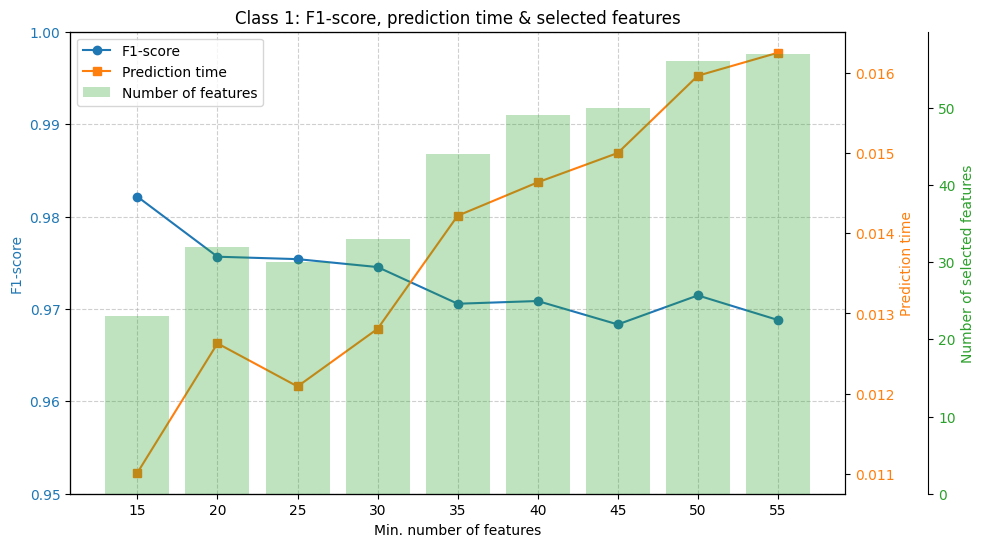

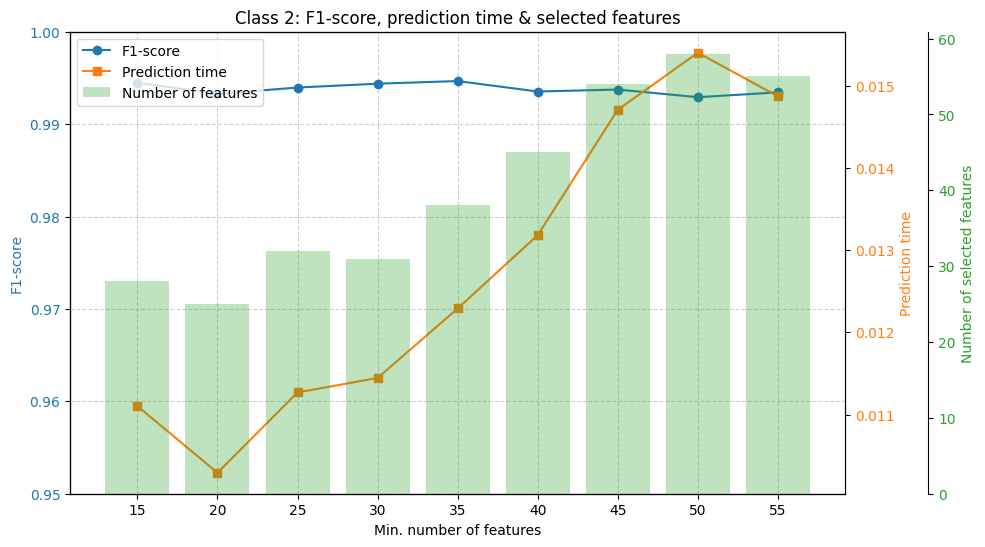

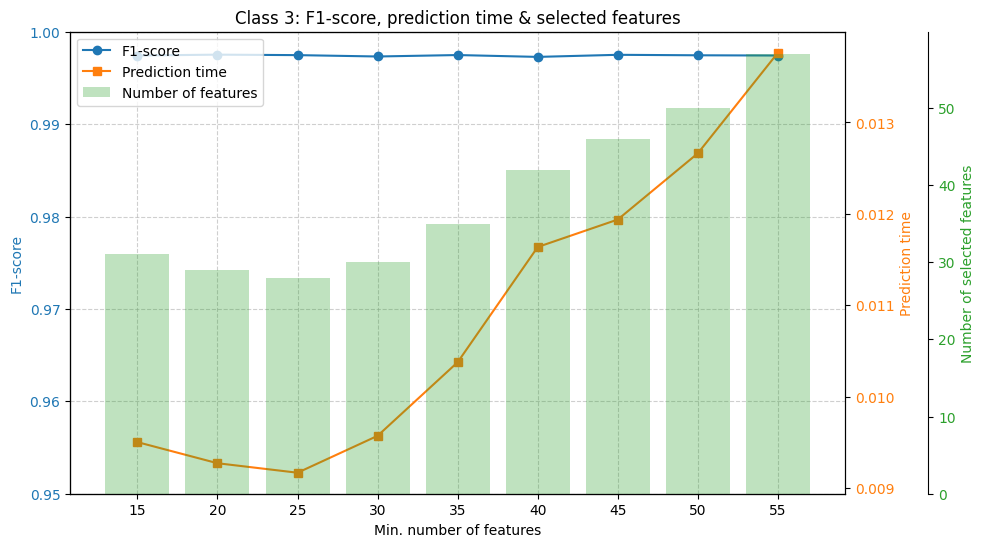

In [8]:
# Crear la figura y los ejes
for i in range(3):
    # Crear la figura y los ejes
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Eje X: Número mínimo de características
    x_positions = range(len(min_features_list))

    # Eje Y para F1-score y Tiempo de predicción
    ax1.set_xlabel('Min. number of features')
    ax1.set_ylabel('F1-score', color='tab:blue')
    ax1.plot(x_positions, all_scores[i], marker='o', color='tab:blue', label='F1-score')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    ax1.set_ylim([0.95, 1])  # F1-score entre 0 y 1
    ax1.set_xticks(x_positions)
    ax1.set_xticklabels(min_features_list)
    ax1.grid(True, linestyle='--', alpha=0.6)

    # Crear un segundo eje Y para el Tiempo de predicción
    ax2 = ax1.twinx()
    ax2.set_ylabel('Prediction time', color='tab:orange')
    ax2.plot(x_positions, all_times[i], marker='s', color='tab:orange', label='Prediction time')
    ax2.tick_params(axis='y', labelcolor='tab:orange')

    # Agregar barras para el número de características seleccionadas
    ax3 = ax1.twinx()  # Crear un tercer eje superpuesto
    ax3.spines.right.set_position(("outward", 60))  # Mover el tercer eje a la derecha
    ax3.set_ylabel('Number of selected features', color='tab:green')
    ax3.bar(x_positions, all_num_feat[i], color='tab:green', alpha=0.3, label='Number of features')
    ax3.tick_params(axis='y', labelcolor='tab:green')

    # Combinar leyendas de todos los ejes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    bars, bar_labels = ax3.get_legend_handles_labels()
    ax1.legend(lines1 + lines2 + bars, labels1 + labels2 + bar_labels, loc='upper left')

    # Título y mostrar
    plt.title(f'Class {i+1}: F1-score, prediction time & selected features')
    plt.show()

# Variar features CV

In [ ]:
# Configuraciones iniciales
corr_th = 0.99
n_folds = 5
keys = ['class1', 'class2', 'class3']
exclude_cols = ['class1', 'class2', 'class3', 'Date', 'Timestamp', 'Scr_IP', 'Des_IP']

# Inicialización de resultados
results = {key: {'f1s': [],'times': [],'n_feats': []} for key in keys}

X_origen = df_converted.drop(columns=exclude_cols)
y_origens = [df_converted[key] for key in keys]
scaler = MinMaxScaler()

min_features_list = list(range(15, X_train.shape[1], 5))

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for f, (train_index, test_index) in enumerate(kf.split(X_origen)):
    print(f'Fold {f + 1}')

    # Dividir conjuntos de entrenamiento y prueba
    X_train, X_test = X_origen.iloc[train_index], X_origen.iloc[test_index]
    y_train_tests = [(y.iloc[train_index], y.iloc[test_index]) for y in y_origens]

    X_train = remove_correlated_features(X_train, corr_th)
    X_test = X_test[X_train.columns]

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
        
    # Selección de características
    
    for i, (y_train, y_test) in enumerate(y_train_tests, start=1):
        key = keys[i - 1]
        times = []
        scores = []
        num_feat = []
        
        for min_features in min_features_list:
            print(f'{min_features} minimun features')
            feat_clf = DecisionTreeClassifier()
            feat_sel = RFECV(estimator=feat_clf, step=1, min_features_to_select=min_features, 
                            scoring='f1_macro')
            feat_sel.fit(X_train, y_train[i])

            sel_f = feat_sel.get_support(indices=True)
            num_feat.append(len(sel_f))

            X_tr, X_te = (X_train[:, sel_f], X_test[:, sel_f])
            model = DecisionTreeClassifier()
            model.fit(X_tr, y_train[i])

            start_time = time.time()
            y_pred = model.predict(X_te)
            test_time = time.time() - start_time

            f1 = f1_score(y_test[i], y_pred, average='macro')
            scores.append(f1)
            times.append(test_time)

        results[key]['f1s'].append(scores)
        results[key]['times'].append(times)
        results[key]['n_feats'].append(num_feat)



###########################



###########################   

In [ ]:
# Promedio de métricas
print('Mean features:')
for key in keys:
    mean_fea = np.mean([len(fea) for fea in results[key]['features']])
    print(f"{key} - mean features: {mean_fea:.2f}")

for key in keys:
    print(f"Results for {key}:")
    for metric_name in ['accuracies', 'precisions', 'recalls', 'f1s', 'times']:
        ave_score = np.mean(results[key][metric_name])
        print(f"Ave. {metric_name.capitalize()}: {ave_score:.4f}")
    print('')